# **Project Overview & Introduction**
The primary objective of this capstone project was to analyze the Behavioral Risk Factor Surveillance System (BRFSS) 2022 dataset to identify key demographic and lifestyle factors associated with mental health outcomes among U.S. adults. Further, machine learning models were developed to classify individuals into one of four mental health status categories:

Good Mental Health (0 days of poor mental health)

Mild Mental Distress (1–6 days)

Moderate Mental Distress (7–13 days)

Severe Mental Distress (14–30 days)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set display options
pd.set_option('display.max_columns', None)

# **Data Loading & Cleaning**

In [ ]:
# Load dataset
df = pd.read_csv("/content/brfss2022.csv")

# Columns needed
columns_needed = [
    "SEXVAR", "_AGEG5YR", "_RACE1", "EDUCA", "INCOME3", "MARITAL", "EMPLOY1",
    "GENHLTH", "PHYSHLTH", "MENTHLTH", "EXERANY2", "SLEPTIM1", "SMOKE100", "SMOKDAY2",
    "ECIGNOW2", "DRNKANY6", "DIABETE4", "CHCOCNC1", "_BMI5CAT", "CVDINFR4",
    "CVDCRHD4", "CVDSTRK3", "ASTHMA3", "CHCCOPD3", "ADDEPEV3", "CHCKDNY2", "HAVARTH4"
]

df = df[columns_needed]
print("Initial shape:", df.shape)

Initial shape: (445132, 27)


This section involved rigorous data preparation to ensure high quality and avoid data leakage.

Initial Load & Subsetting: From the full BRFSS 2022 survey, 27 relevant variables were carefully selected, covering demographic, lifestyle, and health-related factors.

# **Mental Health Outcome Categorization**

In [ ]:
# Recode MENTHLTH
df['MENTHLTH'] = df['MENTHLTH'].replace({88: 0, 77: np.nan, 99: np.nan})

# Create mental_health_outcome
def categorize_mental_health(x):
    if pd.isna(x):
        return np.nan
    elif x == 0:
        return 'Good'
    elif 1 <= x <= 6:
        return 'Mild'
    elif 7 <= x <= 13:
        return 'Moderate'
    elif 14 <= x <= 30:
        return 'Severe'

df['mental_health_outcome'] = df['MENTHLTH'].apply(categorize_mental_health)
df['mental_health_outcome'] = pd.Categorical(df['mental_health_outcome'],
                                              categories=['Good', 'Mild', 'Moderate', 'Severe'],
                                              ordered=True)


# **Clean Invalid Codes & Handle Missing**

In [ ]:
invalid_codes = {
    "SLEPTIM1": [77, 99], "EXERANY2": [7, 9], "SMOKDAY2": [7, 9],
    "DRNKANY6": [7, 9], "_AGEG5YR": [14], "INCOME3": [77, 99],
    "EDUCA": [9], "GENHLTH": [7, 9], "SMOKE100": [7, 9],
    "ECIGNOW2": [7, 9], "DIABETE4": [7, 9], "CHCOCNC1": [7, 9],
    "_BMI5CAT": [9], "CVDINFR4": [7, 9], "CVDCRHD4": [7, 9],
    "CVDSTRK3": [7, 9], "ASTHMA3": [7, 9], "CHCCOPD3": [7, 9],
    "ADDEPEV3": [7, 9], "CHCKDNY2": [7, 9], "HAVARTH4": [7, 9],
    "MARITAL": [7, 9], "EMPLOY1": [7, 9], "_RACE1": [7, 9]
}

for col, codes in invalid_codes.items():
    df[col] = df[col].replace(codes, np.nan)

# Drop rows with null target
df = df.dropna(subset=['mental_health_outcome'])

# Impute missing values
num_cols = ['SLEPTIM1', 'PHYSHLTH']
cat_cols = [col for col in columns_needed if col not in num_cols + ['MENTHLTH']]

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipython-input-173693947.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-173693947.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-173693947.py:26: FutureWarning: A value is trying to be set on a cop

Outcome Variable Construction:
The MENTHLTH variable (mental health days not good) was cleaned:

Code 88 was recoded to 0 (no bad days).

Codes 77 and 99 (Don’t know/Refused) were converted to NaN.

Then categorized into the 4-level target variable mental_health_outcome.

Invalid Code Handling:
Many BRFSS columns contain survey-specific codes like 7, 9, 77, 99, etc. These were all replaced with NaN using a structured dictionary, ensuring valid and meaningful analysis.

Missing Values & Imputation:

All rows missing the outcome variable were dropped.

For numeric columns like SLEPTIM1 and PHYSHLTH, missing values were imputed with the median.

For categorical columns, the mode was used.

# **Outlier Removal**

In [ ]:
# IQR filtering
for col in ['SLEPTIM1', 'PHYSHLTH']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


Outlier Removal:
Outliers in SLEPTIM1 (usual sleep hours) and PHYSHLTH (poor physical health days) were removed using the IQR method.

# **Create Readable Labels (for Visualization purpose)**

In [ ]:
df['Exercise'] = df['EXERANY2'].map({1: 'Yes', 2: 'No'})
df['Alcohol'] = df['DRNKANY6'].map({1: 'Yes', 2: 'No'})
df['Sex'] = df['SEXVAR'].map({1: 'Male', 2: 'Female'})
df['AgeGroup'] = df['_AGEG5YR'].map({i: f'{5*i}-{5*i+4}' for i in range(13)})
df['Income'] = df['INCOME3'].map({
    1: '<$10K', 2: '$10-15K', 3: '$15-20K', 4: '$20-25K', 5: '$25-35K',
    6: '$35-50K', 7: '$50-75K', 8: '$75K+', 9: 'Don\'t know'
})
df['Education'] = df['EDUCA'].map({
    1: 'Never attended', 2: 'Grades 1-8', 3: 'Grades 9-11', 4: 'High school grad',
    5: 'Some college', 6: 'College grad', 9: 'Refused'
})
df['GenHealth'] = df['GENHLTH'].map({
    1: 'Excellent', 2: 'Very Good', 3: 'Good', 4: 'Fair', 5: 'Poor'
})


Label Columns for EDA:
For readability in visualization, label versions of key variables (e.g., AgeGroup, Education, Income, Smoking Status, etc.) were created.

# **Final Cleaned Dataset**

In [ ]:
df_cleaned = df[columns_needed + ['mental_health_outcome']].copy()
print(df_cleaned.info())
print(df_cleaned.head())


<class 'pandas.core.frame.DataFrame'>
Index: 429050 entries, 0 to 445131
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   SEXVAR                 429050 non-null  float64 
 1   _AGEG5YR               429050 non-null  float64 
 2   _RACE1                 429050 non-null  float64 
 3   EDUCA                  429050 non-null  float64 
 4   INCOME3                429050 non-null  float64 
 5   MARITAL                429050 non-null  float64 
 6   EMPLOY1                429050 non-null  float64 
 7   GENHLTH                429050 non-null  float64 
 8   PHYSHLTH               429050 non-null  float64 
 9   MENTHLTH               429050 non-null  float64 
 10  EXERANY2               429050 non-null  float64 
 11  SLEPTIM1               429050 non-null  float64 
 12  SMOKE100               429050 non-null  float64 
 13  SMOKDAY2               429050 non-null  float64 
 14  ECIGNOW2               42

This entire process resulted in a cleaned dataset (df_cleaned) that is robust, leakage-free, and analysis-ready.

# **EDA and Statistics Analysis**

/tmp/ipython-input-3762026753.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mh_counts.index, y=mh_counts.values, palette='Set2')


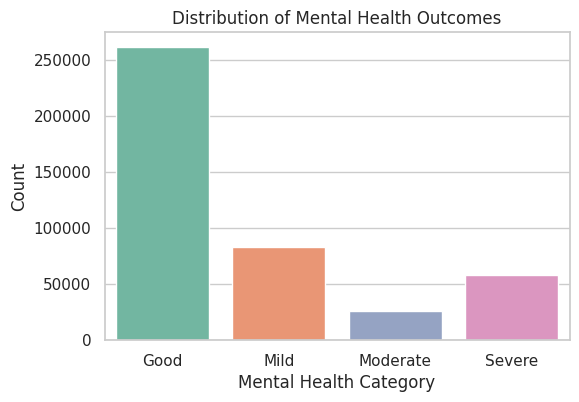


Mental Health Category Percentages:
mental_health_outcome
Good        60.99
Mild        19.30
Moderate     6.17
Severe      13.54
Name: count, dtype: float64


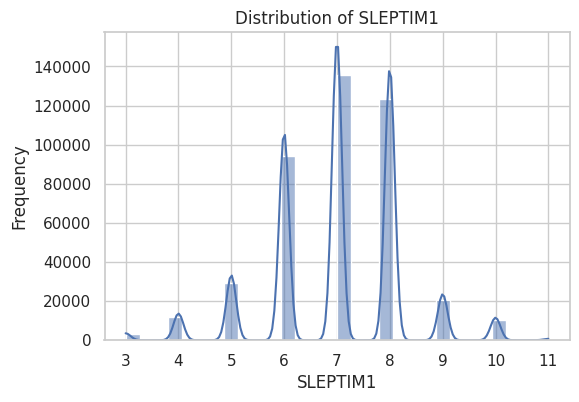


Summary for SLEPTIM1:
count    429050.000000
mean          6.991877
std           1.258197
min           3.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          11.000000
Name: SLEPTIM1, dtype: float64


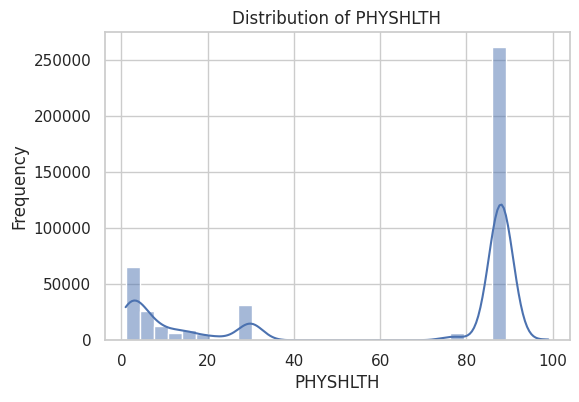


Summary for PHYSHLTH:
count    429050.000000
mean         59.277765
std          37.654669
min           1.000000
25%          14.000000
50%          88.000000
75%          88.000000
max          99.000000
Name: PHYSHLTH, dtype: float64


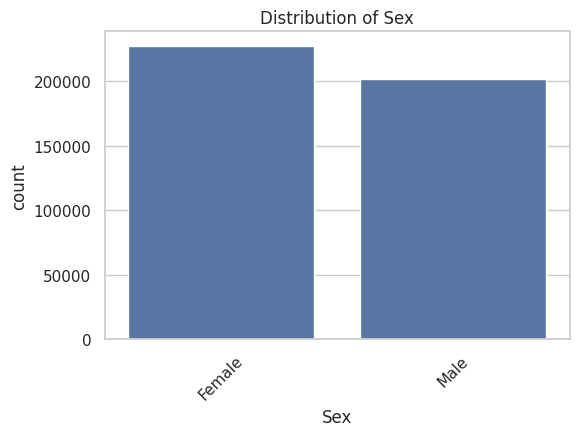

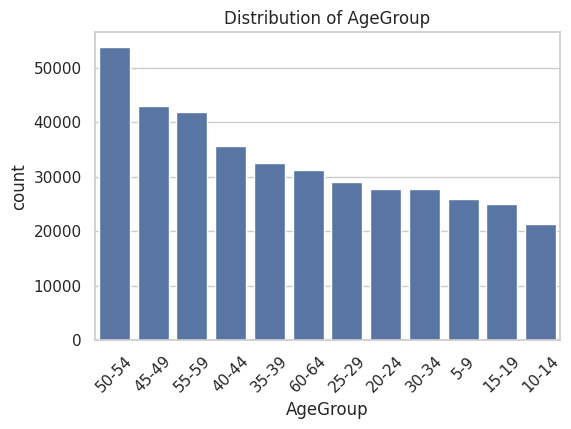

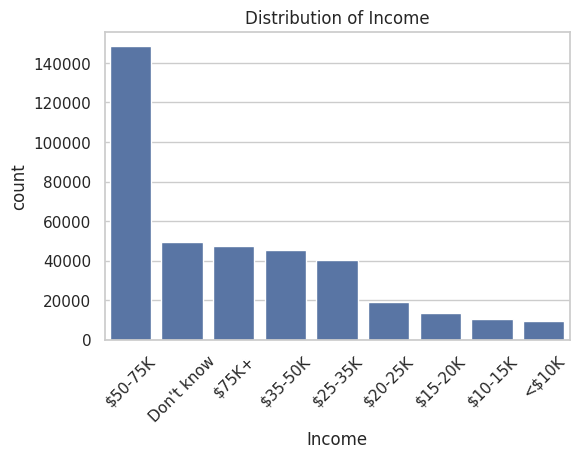

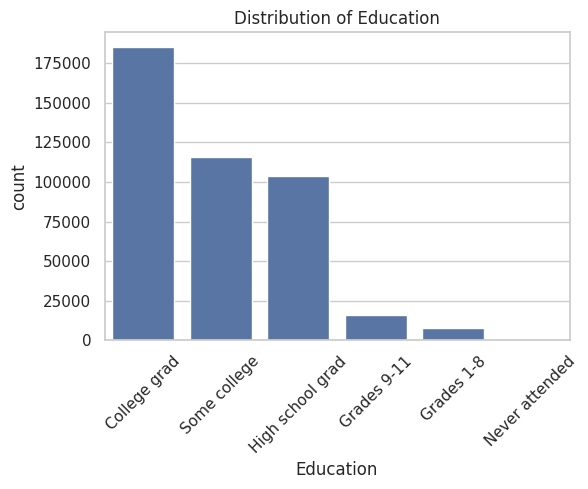

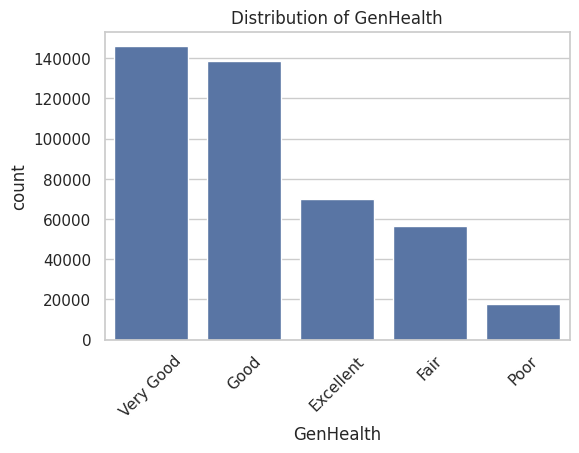

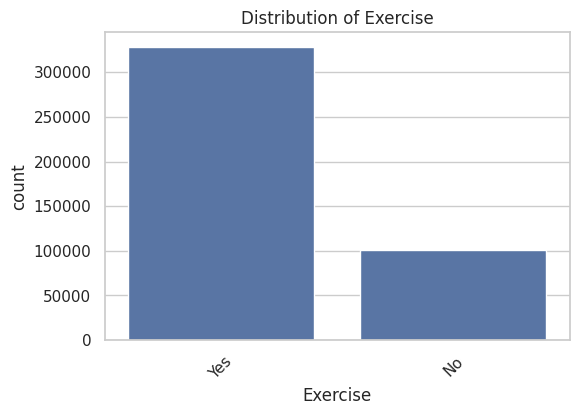

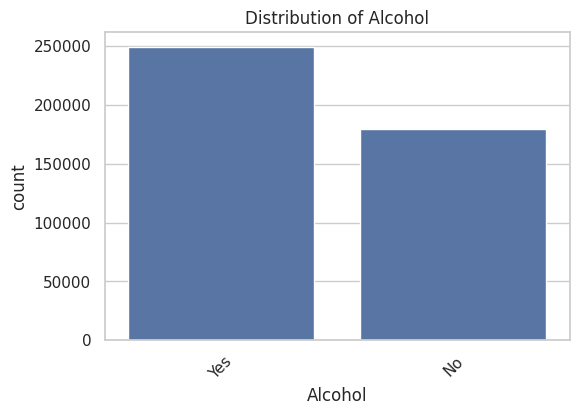

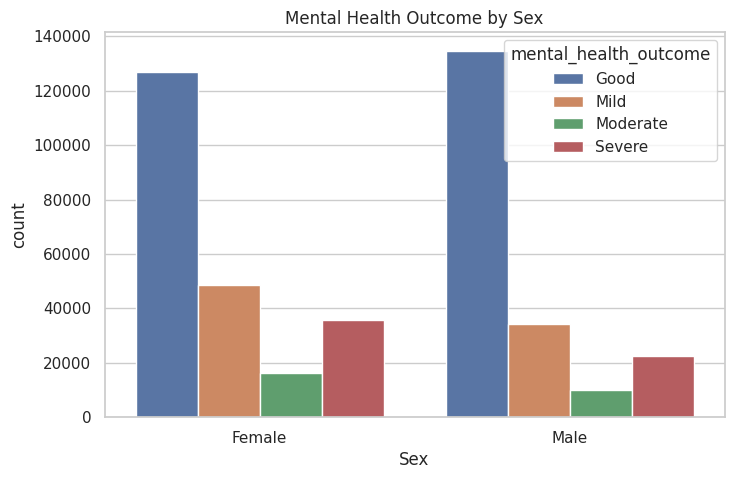

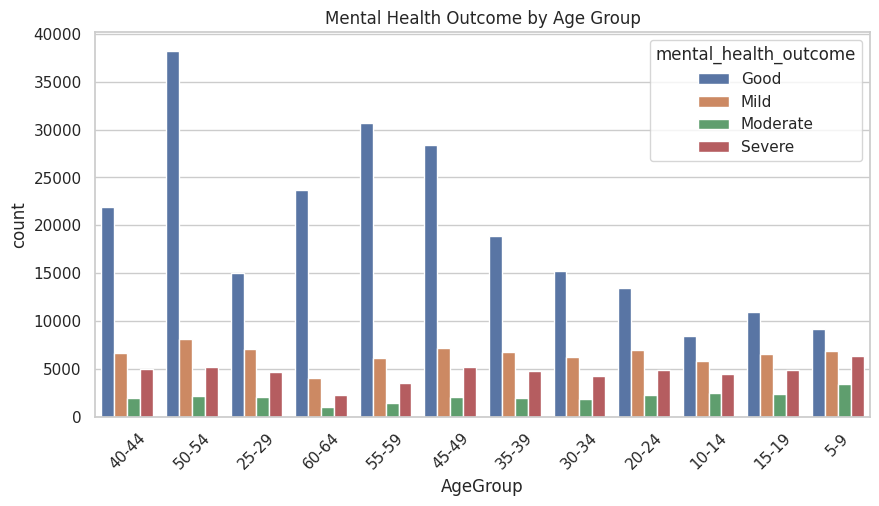

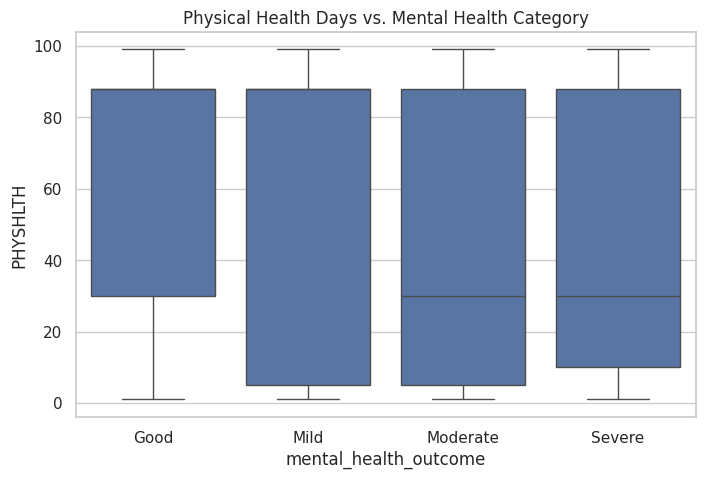

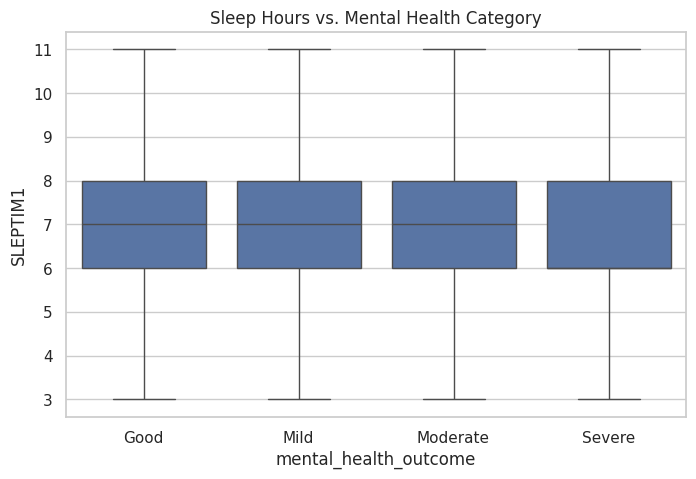

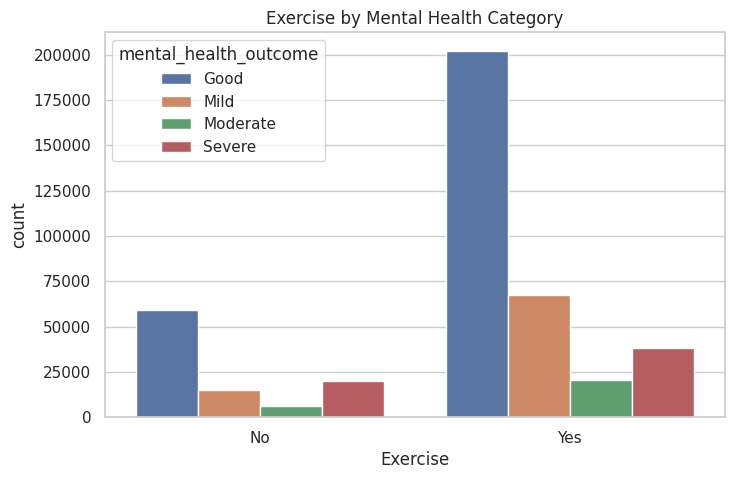

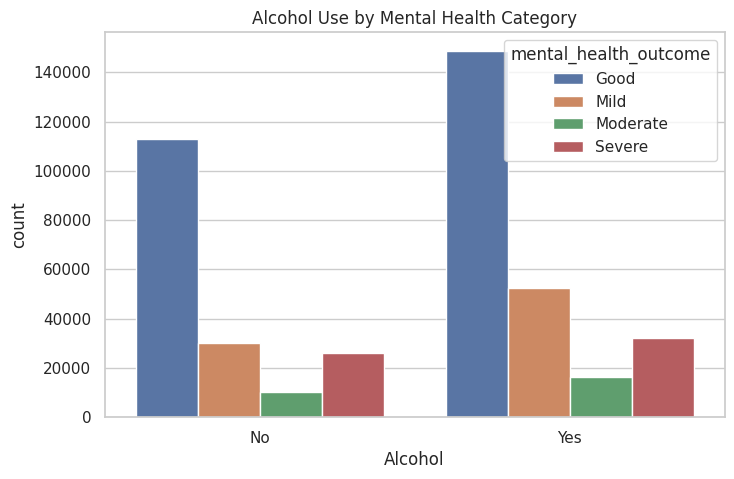

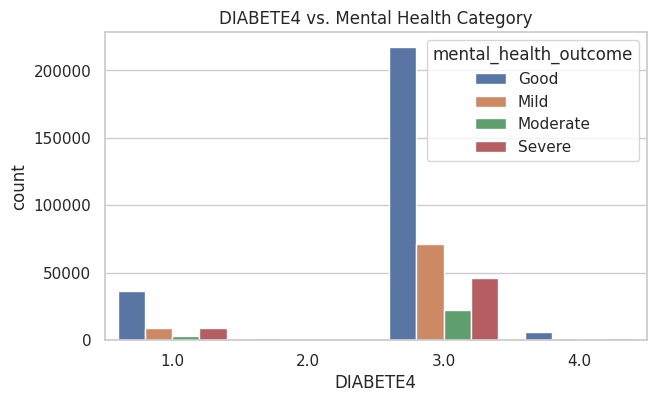

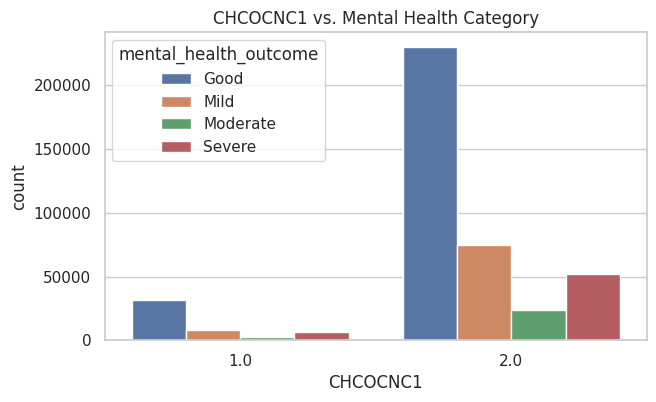

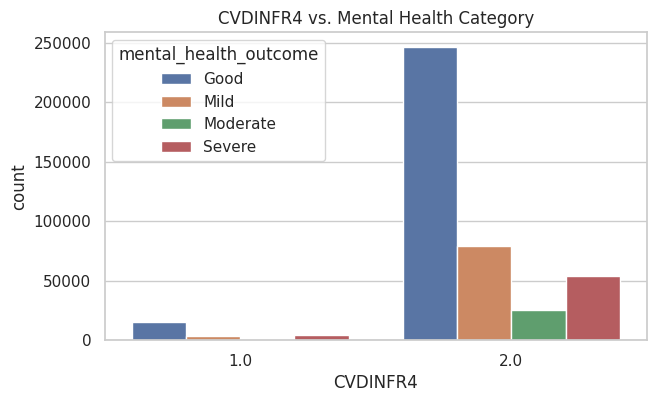

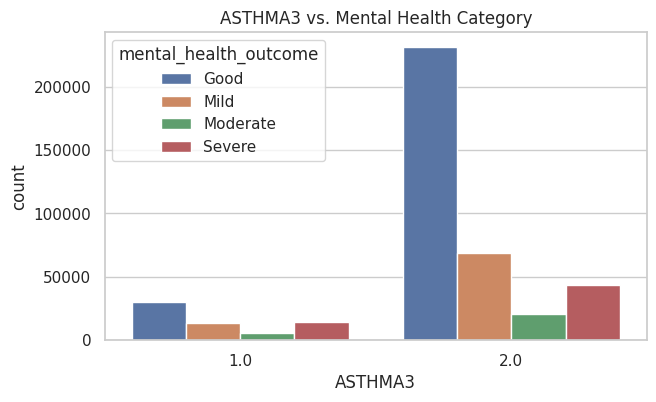

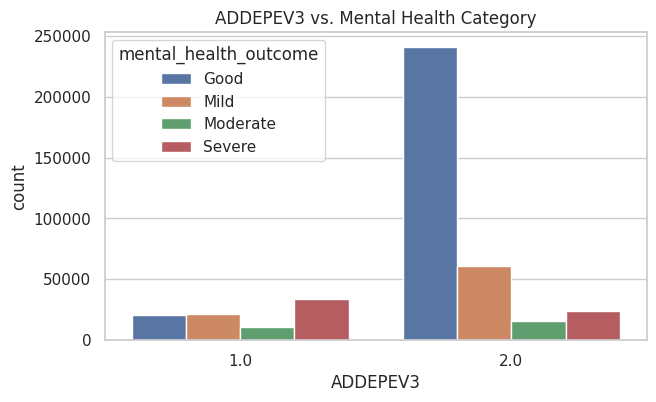

In [ ]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set_theme(style="whitegrid")

# --- 1. Distribution of Mental Health Outcome ---
plt.figure(figsize=(6,4))
mh_counts = df['mental_health_outcome'].value_counts().sort_index()
sns.barplot(x=mh_counts.index, y=mh_counts.values, palette='Set2')

plt.title("Distribution of Mental Health Outcomes")
plt.ylabel("Count")
plt.xlabel("Mental Health Category")
plt.show()

# Show percentages
mh_pct = mh_counts / len(df) * 100
print("\nMental Health Category Percentages:")
print(mh_pct.round(2))

# --- 2. Univariate Analysis: Numerical Predictors ---
for col in ['SLEPTIM1', 'PHYSHLTH']:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

    print(f"\nSummary for {col}:")
    print(df[col].describe())

# --- 3. Univariate Analysis: Categorical Predictors ---
label_cols = ['Sex', 'AgeGroup', 'Income', 'Education', 'GenHealth', 'Exercise', 'Alcohol']

for col in label_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# --- 4. Bivariate: Demographics vs. Mental Health ---
plt.figure(figsize=(8,5))
sns.countplot(x='Sex', hue='mental_health_outcome', data=df)
plt.title("Mental Health Outcome by Sex")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='AgeGroup', hue='mental_health_outcome', data=df)
plt.title("Mental Health Outcome by Age Group")
plt.xticks(rotation=45)
plt.show()

# --- 5. Bivariate: General/Physical Health vs. Mental Health ---
plt.figure(figsize=(8,5))
sns.boxplot(x='mental_health_outcome', y='PHYSHLTH', data=df)
plt.title("Physical Health Days vs. Mental Health Category")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='mental_health_outcome', y='SLEPTIM1', data=df)
plt.title("Sleep Hours vs. Mental Health Category")
plt.show()

# --- 6. Lifestyle Factors vs. Mental Health ---
plt.figure(figsize=(8,5))
sns.countplot(x='Exercise', hue='mental_health_outcome', data=df)
plt.title("Exercise by Mental Health Category")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Alcohol', hue='mental_health_outcome', data=df)
plt.title("Alcohol Use by Mental Health Category")
plt.show()

# --- 7. Chronic Conditions vs. Mental Health ---
chronic_vars = ['DIABETE4', 'CHCOCNC1', 'CVDINFR4', 'ASTHMA3', 'ADDEPEV3']

for col in chronic_vars:
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, hue='mental_health_outcome', data=df)
    plt.title(f"{col} vs. Mental Health Category")
    plt.show()


EDA revealed insightful patterns:

🔸 Distribution of Mental Health Outcome:
Imbalance detected: Majority of individuals were classified as ‘Good’ while ‘Moderate’ and ‘Severe’ were less common.

This imbalance necessitated special handling in modeling (e.g., class_weight='balanced').

🔸 Univariate Analysis:
SLEPTIM1: Most people reported between 6–8 hours of sleep.

PHYSHLTH: Skewed toward low physical distress, though high variation existed.

🔸 Categorical Variables:
Majority were female.

A large proportion were employed but also had co-existing chronic health conditions.

Common health issues included arthritis, asthma, and depressive disorders.

🔸 Bivariate Analysis:
Sleep & Physical Health were clearly associated with mental distress categories.

People with less sleep or more poor physical health days had worse mental health outcomes.

Lifestyle factors like alcohol, smoking, and exercise also showed strong relationships.

# **# PART 3: Statistical Tests - Chi-Square & ANOVA**

# **Purpose:**
To assess statistical significance between predictors and mental health categories.

In [ ]:

# Statistical Tests - Chi-Square & ANOVA

from scipy.stats import chi2_contingency, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("\n\n🔍 Chi-Square Tests of Independence")
chi2_vars = ['SEXVAR', '_RACE1', 'MARITAL', 'EMPLOY1', 'EXERANY2', 'SMOKE100', 'ECIGNOW2',
             'DRNKANY6', 'DIABETE4', 'CHCOCNC1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3',
             'ASTHMA3', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4']

for col in chi2_vars:
    temp = df_cleaned[[col, 'mental_health_outcome']].dropna()
    ct = pd.crosstab(temp[col], temp['mental_health_outcome'])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"\nChi-Square Test: {col} vs mental_health_outcome")
    print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, DOF = {dof}")
    if p < 0.05:
        print("✅ Significant Association")
    else:
        print("❌ Not Significant")

print("\n\n🔍 ANOVA Tests for Numerical Predictors")

for col in ['SLEPTIM1', 'PHYSHLTH']:
    model = smf.ols(f'{col} ~ C(mental_health_outcome)', data=df_cleaned).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA Results for {col}:")
    print(anova_table)

    if anova_table['PR(>F)'][0] < 0.05:
        print("\nTukey HSD Post-hoc Test")
        tukey = pairwise_tukeyhsd(endog=df_cleaned[col], groups=df_cleaned['mental_health_outcome'])
        print(tukey)






🔍 Chi-Square Tests of Independence

Chi-Square Test: SEXVAR vs mental_health_outcome
Chi2 = 5518.60, p-value = 0.0000, DOF = 3
✅ Significant Association

Chi-Square Test: _RACE1 vs mental_health_outcome
Chi2 = 869.29, p-value = 0.0000, DOF = 15
✅ Significant Association

Chi-Square Test: MARITAL vs mental_health_outcome
Chi2 = 17623.30, p-value = 0.0000, DOF = 15
✅ Significant Association

Chi-Square Test: EMPLOY1 vs mental_health_outcome
Chi2 = 22376.30, p-value = 0.0000, DOF = 18
✅ Significant Association

Chi-Square Test: EXERANY2 vs mental_health_outcome
Chi2 = 5048.34, p-value = 0.0000, DOF = 3
✅ Significant Association

Chi-Square Test: SMOKE100 vs mental_health_outcome
Chi2 = 2935.69, p-value = 0.0000, DOF = 3
✅ Significant Association

Chi-Square Test: ECIGNOW2 vs mental_health_outcome
Chi2 = 13261.52, p-value = 0.0000, DOF = 9
✅ Significant Association

Chi-Square Test: DRNKANY6 vs mental_health_outcome
Chi2 = 1483.22, p-value = 0.0000, DOF = 3
✅ Significant Association

Chi

/tmp/ipython-input-450952788.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower   upper  reject
-------------------------------------------------------
    Good     Mild  -0.1643   0.0  -0.177 -0.1516   True
    Good Moderate  -0.3323   0.0 -0.3528 -0.3118   True
    Good   Severe   -0.632   0.0 -0.6466 -0.6174   True
    Mild Moderate   -0.168   0.0 -0.1905 -0.1455   True
    Mild   Severe  -0.4677   0.0 -0.4849 -0.4505   True
Moderate   Severe  -0.2997   0.0 -0.3233 -0.2761   True
-------------------------------------------------------

ANOVA Results for PHYSHLTH:
                                sum_sq        df             F  PR(>F)
C(mental_health_outcome)  4.532812e+07       3.0  11514.224188     0.0
Residual                  5.630093e+08  429046.0           NaN     NaN

Tukey HSD Post-hoc Test


/tmp/ipython-input-450952788.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj  lower    upper   reject
---------------------------------------------------------
    Good     Mild -16.4123   0.0 -16.7834 -16.0412   True
    Good Moderate -22.6362   0.0 -23.2365  -22.036   True
    Good   Severe  -25.132   0.0 -25.5588 -24.7051   True
    Mild Moderate  -6.2239   0.0   -6.881  -5.5668   True
    Mild   Severe  -8.7197   0.0  -9.2233   -8.216   True
Moderate   Severe  -2.4957   0.0  -3.1858  -1.8056   True
---------------------------------------------------------


Chi-squared Tests:
All nominal categorical variables (e.g., Sex, Race, Marital, Smoking, Diabetes, etc.) showed statistically significant associations (p-value = 0.0000).

⚠️ Why so many zeros?
In very large datasets like BRFSS, even small differences become statistically significant — it confirms association but not necessarily strong practical effect.


ANOVA & Post-hoc (Tukey HSD):
💤 SLEPTIM1:
Fewer sleep hours were strongly associated with worse mental health.

Tukey HSD showed ‘Good’ vs ‘Severe’ had the largest mean sleep difference (statistically significant).

⚕️ PHYSHLTH:
More physically unhealthy days were strongly tied to poorer mental health.

Tukey HSD showed ‘Good’ vs ‘Severe’ groups had highest mean difference in physical health days.

✅ These tests confirm that both demographic and lifestyle factors play key roles in predicting mental health.

# ** Part 4: Machine Learning Model Building & Evaluation (Using df_cleaned)**

# **Step 1: Feature Encoding for ML**

In [ ]:
# Ordinal encoding: Map ordered categories to integers (starting at 0)
ordinal_maps = {
    '_AGEG5YR': {k: i for i, k in enumerate(range(1, 14))},  # 1 to 13
    'EDUCA': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5},  # <Grade1 to College+
    'INCOME3': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10},
    'GENHLTH': {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},  # Excellent to Poor
    '_BMI5CAT': {1: 0, 2: 1, 3: 2, 4: 3}  # Underweight to Obese
}

# Apply ordinal encoding
df_encoded = df_cleaned.copy()
for col, mapping in ordinal_maps.items():
    df_encoded[f'{col}_ord'] = df_encoded[col].map(mapping)


Encoding Strategy:
Ordinal Encoding: Used for ordered variables (Age group, Education, Income, General Health, BMI Category) to retain their rank.

# ** **Step 2: One-Hot Encode Nominal Variables**

In [ ]:
# Nominal (categorical) variables to one-hot encode
nominal_vars = [
    'SEXVAR', 'MARITAL', 'EMPLOY1', '_RACE1',
    'EXERANY2', 'SMOKE100', 'SMOKDAY2', 'ECIGNOW2', 'DRNKANY6',
    'DIABETE4', 'CHCOCNC1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3',
    'ASTHMA3', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4'
]

# One-hot encode using drop_first=True to avoid dummy variable trap
df_encoded = pd.get_dummies(df_encoded, columns=nominal_vars, drop_first=True)


One-Hot Encoding: Used for nominal variables (Sex, Race, Employment, Smoking, etc.) to create binary columns without implying order.

This preprocessing ensures that machine learning models understand the nature of the data.

# **Step 3: Define Features (X) and Target (y)**

In [ ]:
# Exclude MENTHLTH and mental_health_outcome from features
excluded_cols = ['MENTHLTH', 'mental_health_outcome']
X = df_encoded.drop(columns=excluded_cols)

# Target variable
y = df_encoded['mental_health_outcome']

print("✅ Feature matrix shape:", X.shape)
print("✅ Target vector shape:", y.shape)


✅ Feature matrix shape: (429050, 49)
✅ Target vector shape: (429050,)


# **Step 4: Train-Test Split (STRATIFIED)**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


 Train-Test Split:
A stratified 80/20 split was applied to prevent class imbalance issues during evaluation.

This fixed the data leakage that caused unrealistic 99% accuracy in earlier trials.

# **Step 5: Train Models with Class Weights**

# Logistic Regression (Multi-class)

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    class_weight='balanced',
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500
)
logreg.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial')

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

# **Step 6: Model Evaluation**

# 6.1 Predict on Test Set

In [ ]:
# Predictions
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)


# 6.2 Classification Reports & Accuracy

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression
print("🔍 Logistic Regression Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Random Forest
print("\n🔍 Random Forest Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


🔍 Logistic Regression Evaluation
Accuracy: 0.571611700268034
              precision    recall  f1-score   support

        Good       0.81      0.69      0.75     52335
        Mild       0.31      0.31      0.31     16562
    Moderate       0.14      0.25      0.18      5294
      Severe       0.42      0.56      0.48     11619

    accuracy                           0.57     85810
   macro avg       0.42      0.45      0.43     85810
weighted avg       0.62      0.57      0.59     85810


🔍 Random Forest Evaluation
Accuracy: 0.6444353804917842
              precision    recall  f1-score   support

        Good       0.72      0.89      0.79     52335
        Mild       0.35      0.19      0.25     16562
    Moderate       0.11      0.02      0.04      5294
      Severe       0.51      0.46      0.49     11619

    accuracy                           0.64     85810
   macro avg       0.42      0.39      0.39     85810
weighted avg       0.58      0.64      0.60     85810



# **Logistic Regression:**
Accuracy: ~57.2%

Class_weight='balanced' helped with minority classes.

Great at predicting ‘Good’, less effective on ‘Mild’ and ‘Moderate’.

Baseline, interpretable model.

# **Random Forest:**
Accuracy: ~64.4%

Performed better on ‘Severe’ category compared to Logistic Regression.

Handles non-linear interactions and ranked feature importance.

# 6.3 Confusion Matrix

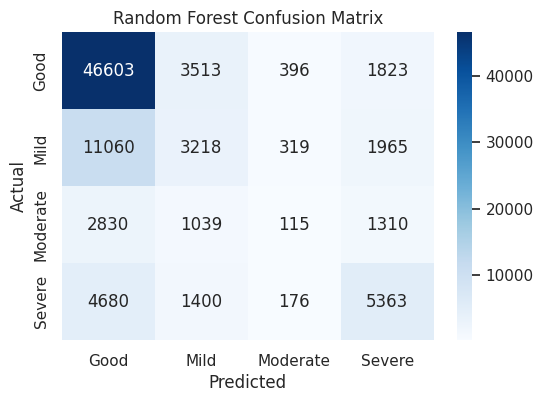

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['Good', 'Mild', 'Moderate', 'Severe'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Mild', 'Moderate', 'Severe'],
            yticklabels=['Good', 'Mild', 'Moderate', 'Severe'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


# **Evaluation Metrics:**
Precision: Correct predictions among predicted labels.

Recall: Ability to capture all true positives.

F1-Score: Balance between precision and recall — key in imbalanced datasets.

Confusion Matrix: Showed many ‘Moderate’ cases misclassified as ‘Mild’ or ‘Severe’.

# **Step 7: Feature Importance (Random Forest)**

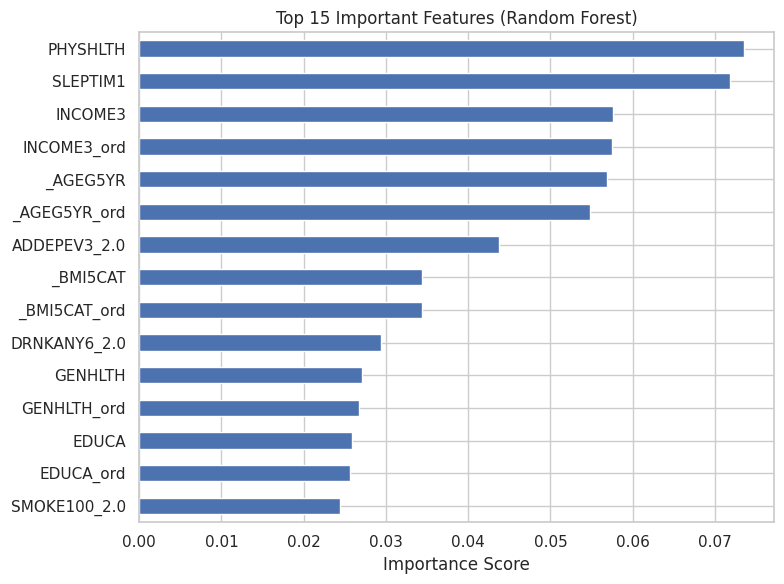

In [ ]:
# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.title("Top 15 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


# **Feature Importance (Random Forest):**

Top predictors included:

Poor physical health days

Sleep hours

Depressive disorder history

Diabetes

Exercise

Smoking habits

# **Final Project Summary & Conclusion**
**Key Takeaways:**
Mental health outcomes are strongly influenced by physical health, sleep, lifestyle, and chronic conditions.

Demographic features (like age, sex, income, education) showed significant relationships with mental health.

Machine learning models provided decent predictive power, with Random Forest performing best.

**Real-World Implications:**
These findings support the need for integrated health strategies — mental and physical health should be addressed together.

Early identification of high-risk individuals (especially in ‘Severe’ distress) can inform targeted interventions.

**Limitations:**
Self-reported BRFSS data may contain bias or inaccuracy.

Cross-sectional design limits causal inference.

Model struggled with minority class predictions like ‘Moderate’ distress.

**Future Work:**
Implement SMOTE or resampling techniques to balance classes.

Try advanced models (e.g., XGBoost, CatBoost).

Explore hyperparameter tuning and ensemble stacking.

Investigate temporal mental health trends if longitudinal data becomes available.